# Meteorological Data Download

This notebook aims at accessing the reference meteorological data for the processing of the Water Quality Parameters (WQPs) maps. The data acquisition will be performed using the Socrata python API to request the data from the [Open Data Portal of Lombardy Region](https://www.dati.lombardia.it/).

## 1. Define Workspace

In [1]:
# Config Libraries
import os
from dotenv import load_dotenv
# API requests
from sodapy import Socrata
# Data Management
import numpy as np
import pandas as pd
import geopandas as gpd
# Plotting
import matplotlib.pyplot as plt

In [2]:
cwd = {
    'wqp_path': './in/satellite_imagery/wqp_parameters',
    'simile_lakes': './vector/simile_laghi'
}    

## 2. Setup Socrata Client

For this step, it is necessary to create an account in the [Open Data Portal of Lombardy Region](https://www.dati.lombardia.it/login). Once your account is created, go to "My profile" section of your account to request the App Token to allow you requesting data from the catalog.

In [3]:
%%capture
load_dotenv()

Fill in the `./notebooks/.env` file with your credentials accordingly to setup the client that will enable the requests to the catalog.

In [4]:
url = os.environ['SOCRATA_DATA_PROVIDER']
user = os.environ['SOCRATA_USER']
password = os.environ['SOCRATA_PASSWORD']
token = os.environ['SOCRATA_APP_TOKEN']

In [5]:
client = Socrata(
        url,
        app_token = token,
        username = user,
        password = password,
        timeout=100000
)

Each dataset can be requested using the Socrata API by means of an id. In this case, we will request the time series for the current past month of meteorological data.

* Meteorological Stations Location: nf78-nj6b
* Meteorological Stations Time Series: 647i-nhxk

Notice that for the time series an additional parameters is included in the GET request. The parameter corresponds to a condition for the ID of the station of interest in Como Province (Tremezzo).

**NOTE:** The time series are also accessible through a module request directly to [ARPA Lombardia](https://www.arpalombardia.it/Pages/Meteorologia/Richiesta-dati-misurati.aspx#).

In [6]:
meteoStations = client.get('nf78-nj6b')
meteoData = client.get('647i-nhxk',IdSensore='14606', limit = 100000)

In [7]:
# Pass data to dataframe
df_SL = gpd.GeoDataFrame(meteoStations)
gdf_SL = gpd.GeoDataFrame(df_SL, geometry=gpd.points_from_xy(df_SL.lat, df_SL.lng))
df_TS = pd.DataFrame(meteoData)
# Lakes shapes
df_lakes = gpd.read_file(os.path.join(cwd['simile_lakes'],'simile_laghi.shp'))

## 3. Data Review

**IMPORTANT:** In case of need of data previous to the current month, you must update the initial archive by adding the corresponding year dataset through the method presented in the [Appendix]('Appendix') section

In [8]:
df_TS.head()

,idsensore,data,valore,idoperatore,stato
0,14606,2022-09-01T01:00:00.000,20.3,1,VA
1,14606,2022-09-01T03:50:00.000,19.4,1,VA
2,14606,2022-09-01T02:30:00.000,20,1,VA
3,14606,2022-09-01T01:10:00.000,20.3,1,VA
4,14606,2022-09-01T05:00:00.000,19,1,VA


In [9]:
#The coulmns must be renamed to fit the existing data
keysData = {
    'idsensore':'IdSensore',
    'data':'Data',
    'valore':'Valore',
    'idoperatore':'idOperatore',
    'stato':'Stato',
}
df_TS.rename(columns = keysData, inplace = True)

In [10]:
df_TS.head()

,IdSensore,Data,Valore,idOperatore,Stato
0,14606,2022-09-01T01:00:00.000,20.3,1,VA
1,14606,2022-09-01T03:50:00.000,19.4,1,VA
2,14606,2022-09-01T02:30:00.000,20,1,VA
3,14606,2022-09-01T01:10:00.000,20.3,1,VA
4,14606,2022-09-01T05:00:00.000,19,1,VA


In [11]:
df_TS["IdSensore"] = df_TS['IdSensore'].astype('int')
df_TS["Data"] = pd.to_datetime(df_TS['Data'])
df_TS["Valore"] = df_TS['Valore'].astype('float')
df_TS["idOperatore"] = df_TS['idOperatore'].astype('int')
df_TS["Stato"] = df_TS['Stato'].astype('str')

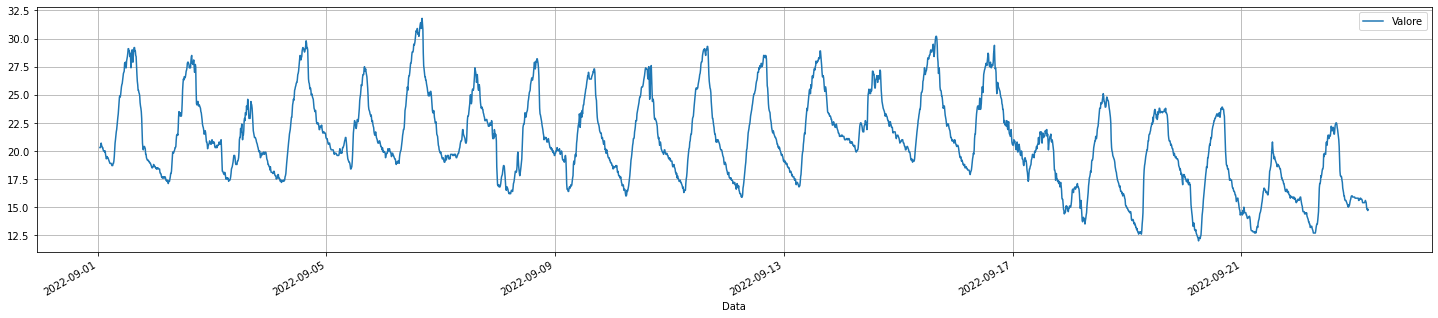

In [12]:
fig, ax = plt.subplots(figsize=(25, 5))
df_TS.plot('Data','Valore', ax=ax)
ax.grid()

In [13]:
print(f'Start Date: {min(df_TS.Data)}')
print(f'End Date: {max(df_TS.Data)}')
print(f'Min value: {min(df_TS.Valore)}')
print(f'Max value: {max(df_TS.Valore)}')
print(f'Mean value: {np.mean(df_TS.Valore)}')
df_TS.head()

Start Date: 2022-09-01 01:00:00
End Date: 2022-09-23 05:10:00
Min value: 12.0
Max value: 31.8
Mean value: 20.908985597996242


,IdSensore,Data,Valore,idOperatore,Stato
0,14606,2022-09-01 01:00:00,20.3,1,VA
1,14606,2022-09-01 03:50:00,19.4,1,VA
2,14606,2022-09-01 02:30:00,20.0,1,VA
3,14606,2022-09-01 01:10:00,20.3,1,VA
4,14606,2022-09-01 05:00:00,19.0,1,VA


## 4. Update Temperature Records

In [15]:
df = pd.read_csv(os.path.join(cwd['wqp_path'],'meteoTemp.csv'))
df["IdSensore"] = df['IdSensore'].astype('int')
df["Data"] = pd.to_datetime(df['Data'], format="%d/%m/%Y %H:%M:%S")
df["Valore"] = df['Valore'].astype('float')
df["idOperatore"] = df['idOperatore'].astype('int')
df["Stato"] = df['Stato'].astype('str')
max(df.Data)

Timestamp('2022-09-01 00:50:00')

In [16]:
df.head()

,IdSensore,Data,Valore,Stato,idOperatore
0,14606,2019-01-01 00:00:00,5.5,VA,1
1,14606,2019-01-01 00:10:00,5.5,VA,1
2,14606,2019-01-01 00:20:00,5.4,VA,1
3,14606,2019-01-01 00:30:00,5.3,VA,1
4,14606,2019-01-01 00:40:00,5.3,VA,1


In [17]:
# Load available records
df = pd.read_csv(os.path.join(cwd['wqp_path'],'meteoTemp.csv'))

df["IdSensore"] = df['IdSensore'].astype('int')
df["Data"] = pd.to_datetime(df['Data'], format='%d/%m/%Y %H:%M:%S')
df["Valore"] = df['Valore'].astype('float')
df["idOperatore"] = df['idOperatore'].astype('int')
df["Stato"] = df['Stato'].astype('str')

print(f'Currently the temperature file hosts {df.shape[0]} records')
print(f'Start Date: {min(df.Data)} records')
print(f'End Date: {max(df.Data)} records')

Currently the temperature file hosts 190858 records
Start Date: 2019-01-01 00:00:00 records
End Date: 2022-09-01 00:50:00 records


In [18]:
# Update the dataframe with the recently retrieved dates for the current month
df = pd.concat([df,df_TS])
df = df.drop_duplicates() #Since a query over the date is not performed, we must make sure that there are no ducplicate records

In [19]:
print(f'The updated the temperature file hosts {df.shape[0]} records')
print(f'Start Date: {min(df.Data)}')
print(f'End Date: {max(df.Data)}')

The updated the temperature file hosts 194052 records
Start Date: 2019-01-01 00:00:00
End Date: 2022-09-23 05:10:00


In [21]:
df["Data"] = pd.to_datetime(df['Data'])
df.to_csv(os.path.join(cwd['wqp_path'],'meteoTemp.csv'),index=False)

## 5. Temperature Acquisition Time

Here, we present the temperature measurements of the selected sensor around the usual time of acquisition of the satellite images for the S3 A/B OLCI sensor.

In [ ]:
# Load available records
df = pd.read_csv(os.path.join(cwd['wqp_path'],'meteoTemp.csv'))
df["IdSensore"] = df['IdSensore'].astype('int')
df["Data"] = pd.to_datetime(df['Data'])
df["Valore"] = df['Valore'].astype('float')
df["idOperatore"] = df['idOperatore'].astype('int')
df["Stato"] = df['Stato'].astype('str')
df = df.set_index('Data')

Sentinel 3 A/B images are regularly retrieved around 10:00.

In [ ]:
df_t = df[df.index.hour==10]

In [ ]:
pv = pd.pivot_table(df_t, index=df_t.index.strftime('%m-%d'), columns=df_t.index.year,
                    values='Valore')
fig, ax = plt.subplots(figsize=(25, 5))
pv.plot(ax=ax)
ax.set_title('Temperature [°C] - Sensor ID: 14606 - Tremezzo, Como' - 10)
ax.grid()

<h2 id='Appendix'>Appendix</h2>

In this section, we will retrieve the historical data of the temperature time series. The data is not available through the API. However, it is possible to download the data as .csv file from the [Open Data Portal of the Lombardy Region](https://www.dati.lombardia.it/). Edit the following cells for retrieving the data prior to the current month.

In [ ]:
# The API available data corresponds to the one of the current month.
# For past data, it is necessary to download the yearly datasets.
url_2019 = "/download/wrhf-6ztd/application%2Fzip"
url_2020 = "/download/erjn-istm/application%2Fzip"
url_2021 = "/download/49n9-866s/application%2Fzip"
url_2022 = "/download/mvvc-nmzv/application%2Fzip"

In [ ]:
# Compose the request for the years of interest and unzip the files.
import zipfile
import os
def downloadOldMeteo(url, out_path, file_name):
    response = requests.get(url)
    zip_name = out_path+file_name
    open(zip_name, "wb").write(response.content)
    with zipfile.ZipFile(zip_name, 'r') as zip_ref:
        zip_ref.extractall(out_path)
    os.remove(zip_name)

In [ ]:
# Execute the records download
downloadOldMeteo('https://'+os.environ['SOCRATA_DATA_PROVIDER']+url_2019,"./meteo","/2019.zip")
downloadOldMeteo('https://'+os.environ['SOCRATA_DATA_PROVIDER']+url_2020,"./meteo","/2020.zip")
downloadOldMeteo('https://'+os.environ['SOCRATA_DATA_PROVIDER']+url_2021,"./meteo","/2021.zip")
downloadOldMeteo('https://'+os.environ['SOCRATA_DATA_PROVIDER']+url_2022,"./meteo","/2022.zip")

In [ ]:
# Create list of dataframes with the historical records for the station of interest.
# This step may take some time since each .csv file contains over 3e6 records for the whole meteorological network of sensors of ARPA Lombardia. 
l = []
for root, dirs, files in os.walk('./meteo'):
    for f in files:
        if f.endswith('.csv'):
            print(f)
            df = pd.read_csv(os.path.join(root,f))
            df = df[df['IdSensore']==14606]
            l.append(df) 
df = pd.concat(l)
df.to_csv(os.path.join(cwd['wqp_path'],'meteoTemp.csv'),index=False)

In [ ]:
# df = pd.concat(l)
df.to_csv(os.path.join(cwd['wqp_path'],'meteoTemp.csv'),index=False,encoding='utf-8')

In [ ]:
# Uncomment the following line if the historical meteo data has been aggregated previously
df = pd.read_csv(os.path.join(cwd['wqp_path'],'meteoTemp.csv'))
df["IdSensore"] = df['IdSensore'].astype('int')
df["Data"] = pd.to_datetime(df['Data'], format='%d/%m/%Y %H:%M:%S')
df["Valore"] = df['Valore'].astype('float')
df["Stato"] = df['Stato'].astype('str')
df["idOperatore"] = df['idOperatore'].astype('int')

In [ ]:
df = df.set_index('Data')

In [ ]:
pv = pd.pivot_table(df, index=df.index.strftime('%m-%d'), columns=df.index.year,
                    values='Valore')
fig, ax = plt.subplots(figsize=(25, 10))
pv.plot(ax=ax)
ax.grid()

In [ ]:
fig, ax = plt.subplots(4,1,figsize=(20, 15), sharex='col')
i = 0
for year in list(df.index.year.unique()):
    temp = []
    df_y = df[df.index.year==year]
    for month in np.linspace(1,12,12):
        temp.append(list(df_y[df_y.index.month==month]['Valore']))
    ax[i].boxplot(temp)
    ax[i].set_title(f'{year}')
    ax[i].set_ylabel(f'T [°C]')
    ax[i].grid()
    # df_y.boxplot(by=df_y.index.month,column=['Valore'], ax=ax[i], labels=)
    i += 1